In [1]:
from __future__ import absolute_import, division, print_function, unicode_literals

import os
import pandas as pd
import numpy as np
import cv2 as cv
import PIL
from sklearn.cluster import KMeans

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv2D, Flatten, Dropout, MaxPooling2D
from tensorflow.keras.preprocessing.image import ImageDataGenerator

import os
import numpy as np
import matplotlib.pyplot as plt

DATA_LOC = r'C:\Temp\Data\state-farm-distracted-driver-detection'
CSV_LOC = os.path.join(DATA_LOC, 'driver_imgs_list.csv')
IMGS_LOC = os.path.join(DATA_LOC, 'imgs')
TRAIN_LOC = os.path.join(IMGS_LOC, 'train')
VAL_LOC = os.path.join(IMGS_LOC, 'val')
TEST_LOC = os.path.join(IMGS_LOC, 'test')
MODEL_LOC = lambda epochs: r'C:\temp\Data\models\{}.model'.format(epochs)
OUT_LOC = os.path.join(DATA_LOC, 'submission.csv')

In [2]:
tf.config.list_physical_devices()

[PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU'),
 PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [3]:
if True:
    # split data into train/test
    data = pd.read_csv(CSV_LOC)
    from sklearn.model_selection import train_test_split
    train, val = train_test_split(data, test_size=0.2)
if False: #if they don't exist
    # create val dir
    os.mkdir(os.path.join(IMGS_LOC, 'val'))
    for n in range(10):
        os.mkdir(os.path.join(IMGS_LOC, 'val', 'c'+str(n)))
if False:
    import shutil
    #move files from trian dir to val dir
    for src, dst in [(os.path.join(TRAIN_LOC, cn, img), os.path.join(VAL_LOC, cn, img))
                     for cn, img in val.loc[:,['classname','img']].values.tolist()]:
        if os.path.exists(src):
            shutil.move(src,dst)

In [4]:
total_train = train.shape[0]
total_val = val.shape[0]

In [5]:
batch_size = 280
EPOCHS = 10
IMG_HEIGHT = 48#0
IMG_WIDTH = 64#0

In [6]:
train_image_generator = ImageDataGenerator(
    rescale=1./255,
    rotation_range=45,
    width_shift_range=.15,  
    height_shift_range=.15,
    horizontal_flip=True,
    zoom_range=0.5
)

# validation_image_generator = ImageDataGenerator(rescale=1./255)

In [7]:
train_data_gen = train_image_generator.flow_from_directory(batch_size=batch_size,
                                                           directory=TRAIN_LOC,
                                                           shuffle=True,
                                                           target_size=(IMG_HEIGHT, IMG_WIDTH),
                                                           class_mode='categorical')

Found 22424 images belonging to 10 classes.


In [8]:
# val_data_gen = validation_image_generator.flow_from_directory(batch_size=batch_size,
#                                                               directory=VAL_LOC,
#                                                               target_size=(IMG_HEIGHT, IMG_WIDTH),
#                                                               class_mode='categorical')

In [9]:
# This function will plot images in the form of a grid with 1 row and 5 columns where images are placed in each column.
def plotImages(images_arr):
    fig, axes = plt.subplots(1, 5, figsize=(20,20))
    axes = axes.flatten()
    for img, ax in zip( images_arr, axes):
        ax.imshow(img)
        ax.axis('off')
    plt.tight_layout()
    plt.show()

In [10]:
if False:
    sample_training_images, _ = next(train_data_gen)
    plotImages(sample_training_images[:5])

In [11]:
model = Sequential([
    Conv2D(16, 3, padding='same', activation='relu', input_shape=(IMG_HEIGHT, IMG_WIDTH ,3)),
    MaxPooling2D(),
    Dropout(0.2),
    Conv2D(32, 3, padding='same', activation='relu'),
    MaxPooling2D(),
    Dropout(0.2),
    Conv2D(64, 3, padding='same', activation='relu'),
    MaxPooling2D(),
    Dropout(0.2),
    Flatten(),
    Dense(512, activation='relu'),
    Dense(10, activation='softmax')
])

In [12]:
model.compile(optimizer=tf.keras.optimizers.SGD(lr=0.01, momentum=0.9),
              loss=tf.keras.losses.CategoricalCrossentropy(),
              metrics=['accuracy'])

In [13]:
# model = tf.keras.models.load_model(MODEL_LOC(sgd51))
# epochs = 21

In [14]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 48, 64, 16)        448       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 24, 32, 16)        0         
_________________________________________________________________
dropout (Dropout)            (None, 24, 32, 16)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 24, 32, 32)        4640      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 12, 16, 32)        0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 12, 16, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 12, 16, 64)        1

In [15]:
history = model.fit(
    train_data_gen,
    epochs=EPOCHS
) #loss: 2.2938 - accuracy: 0.1316

  ...
    to  
  ['...']
Train for 81 steps
Epoch 1/10
81/81 [==============================] - 53s 653ms/step - loss: 2.3040 - accuracy: 0.1094
Epoch 2/10
81/81 [==============================] - 51s 629ms/step - loss: 2.2970 - accuracy: 0.1178
Epoch 3/10
81/81 [==============================] - 52s 639ms/step - loss: 2.2915 - accuracy: 0.1321
Epoch 4/10
81/81 [==============================] - 51s 633ms/step - loss: 2.2833 - accuracy: 0.1384
Epoch 5/10
81/81 [==============================] - 52s 638ms/step - loss: 2.2621 - accuracy: 0.1593
Epoch 6/10
81/81 [==============================] - 52s 638ms/step - loss: 2.2359 - accuracy: 0.1724
Epoch 7/10
81/81 [==============================] - 52s 637ms/step - loss: 2.2080 - accuracy: 0.1887
Epoch 8/10
81/81 [==============================] - 51s 635ms/step - loss: 2.1896 - accuracy: 0.2010
Epoch 9/10
81/81 [==============================] - 52s 636ms/step - loss: 2.1612 - accuracy: 0.2081
Epoch 10/10
81/81 [============================

In [16]:
list(history.history.keys())

['loss', 'accuracy']

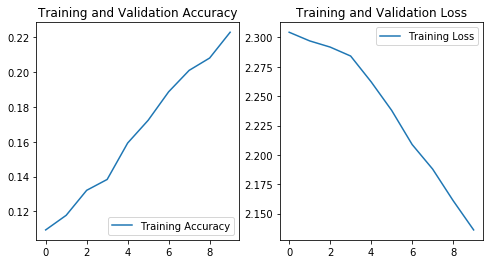

In [17]:
acc = history.history['accuracy']
# val_acc = history.history['val_accuracy']

loss=history.history['loss']
# val_loss=history.history['val_loss']

epochs_range = range(EPOCHS)

plt.figure(figsize=(8, 4))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
# plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
# plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [18]:
# model.save(MODEL_LOC('train30'))

In [19]:
test_image_generator = ImageDataGenerator(rescale=1./255)
test_data_gen = test_image_generator.flow_from_directory(batch_size=batch_size,
                                                         directory=TEST_LOC,
                                                         target_size=(IMG_HEIGHT, IMG_WIDTH),
                                                         class_mode='categorical')

Found 0 images belonging to 0 classes.


In [20]:
# predict = model.predict(test_data_gen)

In [21]:
len(predict)

NameError: name 'predict' is not defined

In [ ]:
submission = pd.DataFrame([[fname]+ pred for fname, pred in (zip(os.listdir(os.path.join(TEST_LOC,'unknown')), predict.tolist()))], columns=['img'] + [f'c{n}' for n in range(10)])
submission

In [ ]:
submission.to_csv(OUT_LOC, index=False)